<a href="https://colab.research.google.com/github/Roflz/stock-prediction/blob/main/predict_V2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
# Install Packages

# Installs/upgrades packages needed for running stock prediction program using Google Colab
# After installing/upgrading, Go to Runtime -> Restart runtime to apply changes

!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:
# Import modules and packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader as pdr
from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [100]:
# parameters
ticker = "GOOG" # stock ticker
years = 2 # years of stock history to get
split = 0.8 # what percent of dataset will be training
epochs = 70 
batch_size = 16
value_to_predict = "Open"
n_future = 30   # Number of days we want to predict into the future
n_past = 50     # Number of past days we want to use to predict the future

In [101]:
# Read Data

# Importing Training Set
# upload files and read csv (optional)
from google.colab import files
# df = files.upload()
# dataset_train = pd.read_csv('GOOG.csv')

# set dates
end_date = date.today()
start_date = end_date - relativedelta(years=years)

# get data
dataset = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)

# Extract dates (will be used in visualization)
dataset.reset_index(inplace=True)
datelist = list(dataset['Date'])
datelist = [dt.datetime.strptime(str(date.date()), '%Y-%m-%d').date() for date in datelist]
dataset_train = dataset.drop(["Date"], axis=1)

# Select features (columns) to be involved in training and predictions
cols = list(dataset_train)[0:5]
dataset_train = dataset_train[cols]

# get predicted column index
pred_column = dataset_train.columns.get_loc(value_to_predict)

print('Dataset shape == {}'.format(dataset.shape))
print('Dataset_train shape (date column removed) == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist)))
print('Features selected: {}'.format(cols))
print('Value to predict: "{}", column {} (zero index)'.format(value_to_predict, pred_column))
dataset.head(5)

Dataset shape == (502, 7)
Dataset_train shape (date column removed) == (502, 5)
All timestamps == 502
Features selected: ['High', 'Low', 'Open', 'Close', 'Volume']
Value to predict: "Open", column 2 (zero index)


,Date,High,Low,Open,Close,Volume,Adj Close
0,2020-08-10,75.203751,73.653999,74.359001,74.805000,25786000.0,74.805000
1,2020-08-11,75.500000,73.900002,74.622002,74.015999,29088000.0,74.015999
2,2020-08-12,75.619301,74.262497,74.278999,75.331001,28740000.0,75.331001
3,2020-08-13,76.862503,75.400253,75.516998,75.922501,29104000.0,75.922501
4,2020-08-14,76.095001,75.143997,75.782997,75.386497,27096000.0,75.386497


In [102]:
# Data Pre-processing

# # removes commas if reading csv
# for i in cols:
#     for j in range(0, len(dataset_train)):
#         dataset_train[i][j] = dataset_train[i][j].replace(',', '')
# # make sure numerical
# dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)

In [103]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler, MinMaxScaler

training_set = np.array(dataset_train)
training_set

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
# print(training_set_scaled)
sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 2:3])

# # scale data between 0 and 1
# sc = MinMaxScaler(feature_range=(0,1))
# training_set_scaled = sc.fit_transform(training_set)
# test_set_scaled = sc.transform(test_set)

# # make separate scaler for predictions
# sc_predict = MinMaxScaler(feature_range=(0,1))
# sc_predict.fit_transform(training_set[:, 2:3])

array([[-1.83368157],
       [-1.8222297 ],
       [-1.8371651 ],
       [-1.78325874],
       [-1.77167632],
       [-1.77383168],
       [-1.74877259],
       [-1.68970639],
       [-1.71117299],
       [-1.63806403],
       [-1.60116139],
       [-1.62709121],
       [-1.57063748],
       [-1.47118511],
       [-1.51514185],
       [-1.48379074],
       [-1.50830568],
       [-1.42743502],
       [-1.34919013],
       [-1.53523709],
       [-1.73281399],
       [-1.68051852],
       [-1.67374779],
       [-1.7273927 ],
       [-1.72085053],
       [-1.7273927 ],
       [-1.68485117],
       [-1.81447896],
       [-1.81010312],
       [-1.93626931],
       [-1.9144323 ],
       [-1.89551274],
       [-1.99947217],
       [-1.9524455 ],
       [-1.86191923],
       [-1.87023605],
       [-1.87805223],
       [-1.8400171 ],
       [-1.88843704],
       [-1.87933655],
       [-1.85893666],
       [-1.88351672],
       [-1.88177495],
       [-1.81730937],
       [-1.71215267],
       [-1

In [104]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, pred_column])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (423, 50, 5).
y_train shape == (423, 1).


In [105]:
# Create a Model. Training
# Building the LSTM based Neural Network

# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [106]:

# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, X_train.shape[2])))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [107]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=epochs, callbacks=[es, rlr, mcp, tb], validation_split=1-split, verbose=1, batch_size=batch_size)

Epoch 1/70
22/22 [==============================] - ETA: 0s - loss: 0.2160
Epoch 1: val_loss improved from inf to 0.54362, saving model to weights.h5
22/22 [==============================] - 32s 613ms/step - loss: 0.2160 - val_loss: 0.5436 - lr: 0.0100
Epoch 2/70
21/22 [===========================>..] - ETA: 0s - loss: 0.0874
Epoch 2: val_loss did not improve from 0.54362
22/22 [==============================] - 5s 249ms/step - loss: 0.0878 - val_loss: 0.6917 - lr: 0.0100
Epoch 3/70
22/22 [==============================] - ETA: 0s - loss: 0.0915
Epoch 3: val_loss did not improve from 0.54362
22/22 [==============================] - 2s 109ms/step - loss: 0.0915 - val_loss: 0.6105 - lr: 0.0100
Epoch 4/70
22/22 [==============================] - ETA: 0s - loss: 0.0767
Epoch 4: val_loss improved from 0.54362 to 0.53006, saving model to weights.h5
22/22 [==============================] - 2s 88ms/step - loss: 0.0767 - val_loss: 0.5301 - lr: 0.0100
Epoch 5/70
21/22 [==========================

In [108]:
# Notes:
# EarlyStopping - Stop training when a monitored metric has stopped improving.
# monitor - quantity to be monitored.
# min_delta - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
# patience - number of epochs with no improvement after which training will be stopped.
# ReduceLROnPlateau - Reduce learning rate when a metric has stopped improving.
# factor - factor by which the learning rate will be reduced. new_lr = lr * factor.
# The last date for our training set is 30-Dec-2016.
# We will perform predictions for the next 20 days, since 2017-01-01 to 2017-01-20.

In [109]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [110]:

# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [111]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Open
2021-02-12,101.478813
2021-02-16,102.075584
2021-02-17,103.013741


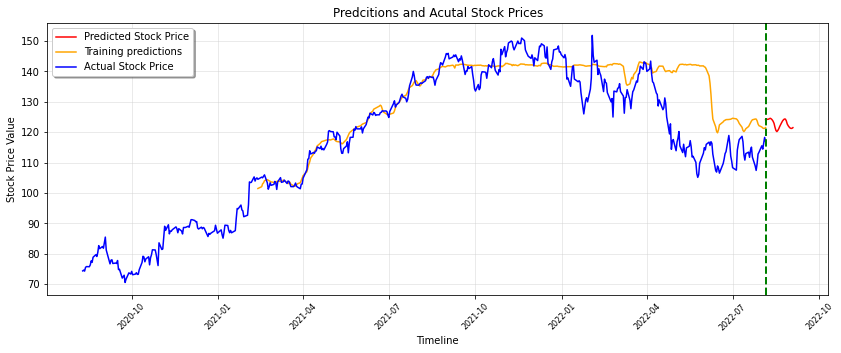

In [112]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Parse training set timestamp
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist
dataset_train.index = pd.to_datetime(dataset_train.index)

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [113]:
# This doesn't work yet
# plot training loss against validation loss

def plot_loss(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

# Train your model for 60 epochs, using X_test and y_test as validation data
h_callback = model.fit(X_train, y_train, epochs=60, validation_data=(X_test, y_test), verbose=0)

# Extract from the h_callback object loss and val_loss to plot the learning curve
plot_loss(h_callback.history['loss'], h_callback.history['val_loss'])



NameError: ignored